In [56]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt

# Exponenciální vyhlazování: Holtova-Wintersova metoda

Holtova-Wintersova metoda trojitého exponenciálního vyhlazování slouží k modelování časových řad s trendem a sezónností. Ostatní probrané metody exp. vyhlazování jsou jejími speciálními případy.

Uvažujme:
- $y_t$ - aktuální měření
- $\hat{y}_{\cdot}$ - predikce
- $m$ - sezónnost (počet vzorků od jedné sezóny do druhé)
- $l_t$ - level (složka hladiny)
- $b_t$ - trend
- $s_t$ - sezónní složka
- $\alpha, \beta^*, \gamma$ - koeficienty

### Aditivní metoda
Aditivní metoda předpokládá, že sezónní složky jsou prakticky stejné a sčítají se (přibližně) do nuly. Model má tvar

$$
\begin{alignat}{2}
\text{Forecast eq.}&&\qquad \hat{y}_{t+h|t} &= l_t + hb_t + s_{t+h-m(k+1)}, \\
\text{Level eq.}&&\qquad l_t &= \alpha (y_t - s_{t-m}) + (1 - \alpha)(l_{t-1} + b_{t-1}),\\
\text{Trend eq.}&&\qquad b_t &= \beta^{*}(l_t - l_{t-1}) + (1 - \beta^{*})b_{t-1}, \\
\text{Seasonal eq.} &&\qquad s_t &= \gamma(y_t - l_{t-1} - b_{t-1}) + (1-\gamma)s_{t-m},
\end{alignat}
$$

kde $k = \lfloor (h-1)/m \rfloor$. Poslední z rovnic vyjadřuje vážený průměr mezi současnou hodnotou sezónnosti (sezónního indexu) a téže veličinou v předchozí sezóně.

### Multiplikativní metoda
Multiplikativní metoda předpokládá, že sezónní složky se mění v závislost na hladině $l_t$. Sezónní komponenta je v modelu vyjádřena jako relativní (procentuální) veličina, srov. s aditivním modelem. Komponentní forma má tvar

$$
\begin{alignat}{2}
\text{Forecast eq.}&&\qquad \hat{y}_{t+h|t} &= (l_t + hb_t)s_{t+h-m(k+1)}, \\
\text{Level eq.}&&\qquad l_t &= \alpha \frac{y_t}{s_{t-m}} + (1 - \alpha)(l_{t-1} + b_{t-1}),\\
\text{Trend eq.}&&\qquad b_t &= \beta^{*}(l_t - l_{t-1}) + (1 - \beta^{*})b_{t-1}, \\
\text{Seasonal eq.} &&\qquad s_t &= \gamma \frac{y_t}{l_{t-1} + b_{t-1}} + (1-\gamma)s_{t-m}.
\end{alignat}
$$

<AxesSubplot:xlabel='datum'>

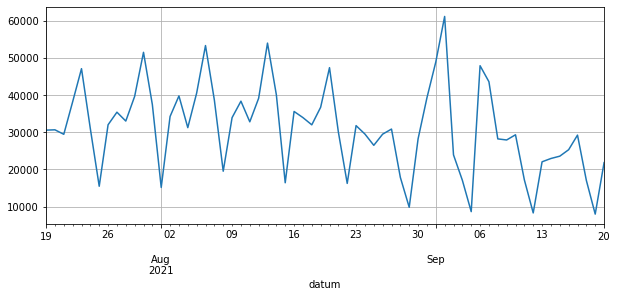

In [67]:
fn = 'https://onemocneni-aktualne.mzcr.cz/api/v1/covid-19/nakazeni-vyleceni-umrti-testy.csv'
#fn = 'nakazeni-vyleceni-umrti-testy.csv'
data = pd.read_csv(fn, index_col=0, parse_dates=True)
dt = data['prirustkovy_pocet_provedenych_testu'].last('10W')
dt.plot(figsize=(10,4))

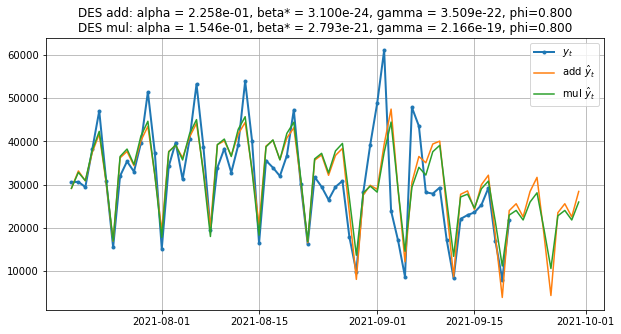

In [72]:
method_add = smt.ExponentialSmoothing(dt, initialization_method="heuristic", freq='D',
                                  trend='add', damped_trend=True, 
                                  seasonal='add', seasonal_periods=7)
method_mul = smt.ExponentialSmoothing(dt, initialization_method="heuristic", freq='D',
                                  trend='mul', damped_trend=True, 
                                  seasonal='mul', seasonal_periods=7)
fit_add = method_add.fit(method='ls')
fit_mul = method_mul.fit(method='ls')
fcast_add = fit_add.forecast(10)
fcast_mul = fit_mul.forecast(10)

plt.figure(figsize=(10, 5))
plt.title(rf"DES add: alpha = {fit_add.model.params['smoothing_level']:.3e}, " 
         + fr"beta* = {fit_add.model.params['smoothing_trend']:.3e}, "
         + fr"gamma = {fit_add.model.params['smoothing_seasonal']:.3e}, "
         + fr"phi={fit_add.model.params['damping_trend']:.3f}" + '\n'
         + fr"DES mul: alpha = {fit_mul.model.params['smoothing_level']:.3e}, " 
         + fr"beta* = {fit_mul.model.params['smoothing_trend']:.3e}, "
         + fr"gamma = {fit_mul.model.params['smoothing_seasonal']:.3e}, "
         + fr"phi={fit_mul.model.params['damping_trend']:.3f}"
         )
plt.plot(dt, marker='.', lw=2, label=r'$y_t$')
plt.plot(fit_add.fittedvalues.append(fcast_add), label=r'add $\hat{y}_t$')
plt.plot(fit_mul.fittedvalues.append(fcast_mul), label=r'mul $\hat{y}_t$')
plt.legend()
plt.show()